In [1]:
import matplotlib.pyplot as plt

from muutils.zanj import ZANJ
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.maze_dataset import MazeDataset, MazeDatasetConfig, MAZE_DATASET_CONFIGS

print(MAZE_DATASET_CONFIGS.keys())

dict_keys(['test-g3-n5-a_dfs'])


In [2]:
zanj: ZANJ = ZANJ(external_list_threshold=8)
cfg: MazeDatasetConfig = MazeDatasetConfig(
	name="test",
	grid_n=3,
	n_mazes=16,
	maze_ctor=LatticeMazeGenerators.gen_dfs,
)

In [3]:
dataset: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
	local_base_path="../data/",
	verbose=True,
	zanj=zanj,
	do_parallel=False,
)

generating & solving mazes: 100%|██████████| 16/16 [00:00<00:00, 1066.98maze/s]


In [4]:
dataset_cpy: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=True,
	do_generate=False,
	local_base_path="../data/",
	verbose=True,
	zanj=zanj,
)


In [5]:
assert dataset.cfg == dataset_cpy.cfg
print(len(dataset.mazes), len(dataset_cpy.mazes))
print(dataset_cpy.mazes[0])
assert all(x == y for x,y in zip(dataset.mazes, dataset_cpy.mazes))

16 16
SolvedMaze(connection_list=array([[[ True, False, False],
        [ True, False,  True],
        [False, False, False]],

       [[ True,  True, False],
        [False,  True, False],
        [ True,  True, False]]]), generation_meta=None, lattice_dim=2, start_pos=array([2, 0]), end_pos=array([2, 2]), solution=array([[2, 0],
       [2, 1],
       [2, 2]]))


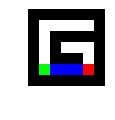

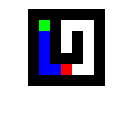

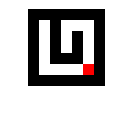

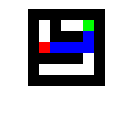

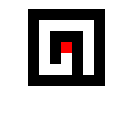

In [9]:
for i in range(5):
	# set image size to 1x1
	fig = plt.figure(figsize=(1,1))
	# remove axes
	fig.add_subplot(111, frameon=False)
	plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
	# remove bounding box
	plt.box(False)
	# plot image
	plt.imshow(dataset.mazes[i].as_pixels())
	plt.show()



In [7]:
dataset_filtered: MazeDataset = dataset.filter_by.path_length(min_length=3)

print(f"{len(dataset.mazes) = }")
print(f"{len(dataset_filtered.mazes) = }")

len(dataset.mazes) = 16
len(dataset_filtered.mazes) = 11


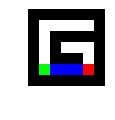

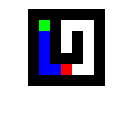

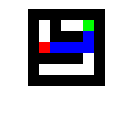

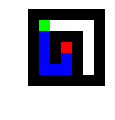

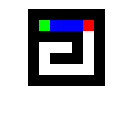

In [11]:
for i in range(5):
	# set image size to 1x1
	fig = plt.figure(figsize=(1,1))
	# remove axes
	fig.add_subplot(111, frameon=False)
	plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
	# remove bounding box
	plt.box(False)
	# plot image
	plt.imshow(dataset_filtered.mazes[i].as_pixels())
	plt.show()
